In [ ]:
import torch
import time
import os
import numpy as np
from models.networks import NGP
from models.rendering import render
from metrics import psnr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datasets import dataset_dict
from datasets.ray_utils import get_rays
from utils import load_ckpt
from train import depth2img
import imageio

dataset_name = 'nerf'
scene = 'Scar'
dataset = dataset_dict[dataset_name](
    f'/home/ubuntu/hdd/data/Jrender_Dataset/{scene}',
    split='train', downsample=1.0
)

# dataset_name = 'nsvf'
# scene = 'Lego'
# dataset = dataset_dict[dataset_name](
#     f'/home/ubuntu/data/nerf_data/Synthetic_NeRF/{scene}',
#     split='test', downsample=1.0
# )

# dataset_name = 'colmap'
# scene = 'bathroom'
# dataset = dataset_dict[dataset_name](
#     f'/home/ubuntu/hdd/data/HDR-NeRF_syndata_8_scenes/{scene}',
#     split='test', downsample=1.0,
# )

# dataset_name = 'nerfpp'
# scene = 'basket'
# dataset = dataset_dict[dataset_name](
#     f'/home/ubuntu/data/nerf_data/lf_data/{scene}',
#     split='test', downsample=1.0,
# )

# dataset_name = 'rtmv'
# scene = '00000'
# dataset = dataset_dict[dataset_name](
#     f'/home/ubuntu/hdd/data/RTMV/amazon_berkeley/{scene}',
#     split='test', downsample=1.0/2,
# )

In [2]:
import cv2
xml_path = "/home/ubuntu/hdd/data/mgtv/camera_parameters/F1_06/1/intrinsic.xml"
fs = cv2.FileStorage(xml_path, cv2.FileStorage_READ)
K = fs.getNode('M').mat()
D = fs.getNode('D').mat()

In [3]:
K

array([[3.36804989e+03, 0.00000000e+00, 1.27352547e+03],
       [0.00000000e+00, 3.36804989e+03, 9.68514002e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [2]:
model = NGP(scale=0.5, rgb_act='Sigmoid').cuda()
# load_ckpt(model, f'ckpts/{dataset_name}/{scene}/epoch=19_slim.ckpt')

GridEncoding: Nmin=16 b=1.31951 F=2 T=2^19 L=16


In [4]:
psnrs = []; ts = []; imgs = []; depths = []
# os.makedirs(f'results/{dataset_name}/{scene}_traj', exist_ok=True)

for img_idx in [0]:#tqdm(range(len(dataset))):
    t = time.time()
    rays_o, rays_d = get_rays(dataset.directions.cuda(), dataset[img_idx]['pose'].cuda())
    results = render(model, rays_o, rays_d,
                     **{'test_time': True,
                        'T_threshold': 1e-2,
                        'exposure': 8*torch.ones(1, device='cuda'),
                        'output_radiance': False,
                        'exp_step_factor': 0*1/256})
    torch.cuda.synchronize()
    ts += [time.time()-t]

#     pred = results['rgb'].reshape(dataset.img_wh[1], dataset.img_wh[0], 3).cpu().numpy()
#     pred = (pred*255).astype(np.uint8)
#     depth = results['depth'].reshape(dataset.img_wh[1], dataset.img_wh[0]).cpu().numpy()
#     depth_ = depth2img(depth)
#     imgs += [pred]
#     depths += [depth_]
#     imageio.imwrite(f'results/{dataset_name}/{scene}_traj/{img_idx:03d}.png', pred)
#     imageio.imwrite(f'results/{dataset_name}/{scene}_traj/{img_idx:03d}_d.png', depth_)

    if dataset.split != 'test_traj':
        rgb_gt = dataset[img_idx]['rgb'].cuda()
        psnrs += [psnr(results['rgb'], rgb_gt).item()]
if psnrs: print(f'mean PSNR: {np.mean(psnrs):.2f}, min: {np.min(psnrs):.2f}, max: {np.max(psnrs):.2f}')
print(f'mean time: {np.mean(ts):.4f} s, FPS: {1/np.mean(ts):.2f}')
print(f'mean samples per ray: {results["total_samples"]/len(rays_d):.2f}')

if len(imgs)>30:
    imageio.mimsave(f'results/{dataset_name}/{scene}_traj/rgb.mp4', imgs, fps=30)
    imageio.mimsave(f'results/{dataset_name}/{scene}_traj/depth.mp4', depths, fps=30)

mean PSNR: 31.80, min: 31.80, max: 31.80
mean time: 0.0614 s, FPS: 16.28
mean samples per ray: 9.49


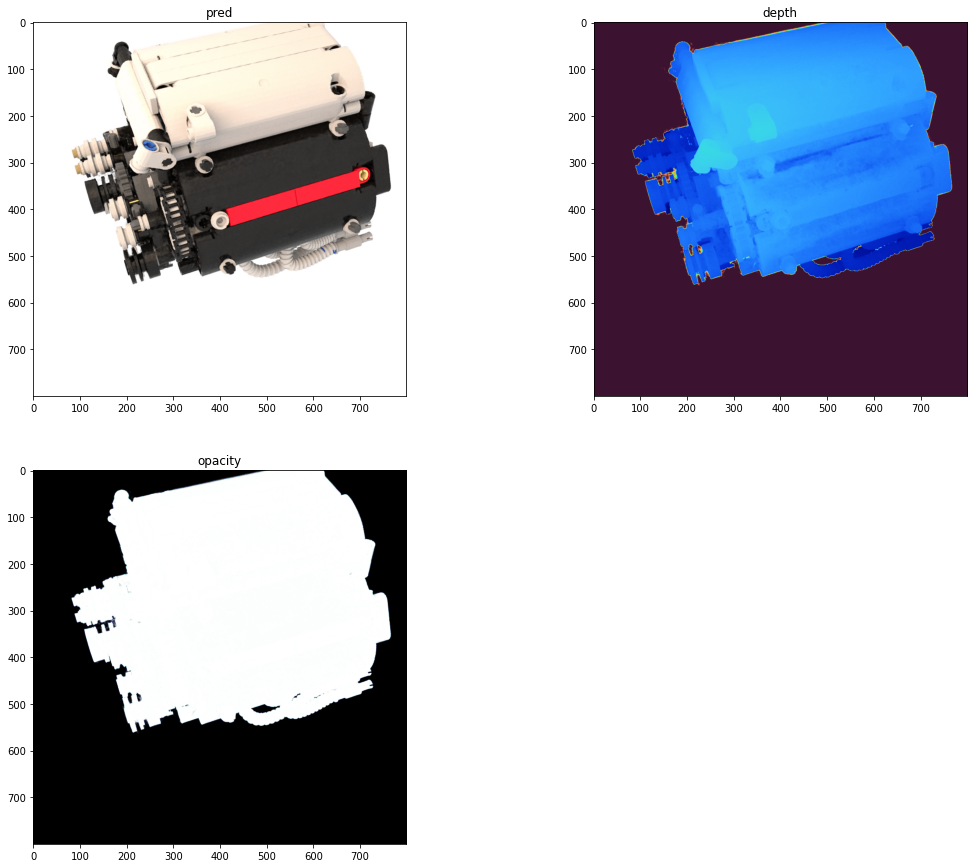

In [5]:
plt.subplots(figsize=(15, 12))
plt.tight_layout()
plt.subplot(221)
plt.title('pred')
pred = results['rgb'].reshape(dataset.img_wh[1], dataset.img_wh[0], 3).cpu().numpy()
plt.imshow(pred)
plt.subplot(222)
plt.title('depth')
depth = results['depth'].reshape(dataset.img_wh[1], dataset.img_wh[0]).cpu().numpy()
depth_ = depth2img(depth)
plt.imshow(depth_)
plt.subplot(223)
plt.title('opacity')
plt.imshow(results['opacity'].reshape(dataset.img_wh[1], dataset.img_wh[0]).cpu().numpy(), 'bone')
plt.show()

In [3]:
from kornia.utils.grid import create_meshgrid3d
import vren

xyz = create_meshgrid3d(model.grid_size, model.grid_size, model.grid_size, False, dtype=torch.int32).reshape(-1, 3)
# _density_bitfield = model.density_bitfield
# density_bitfield = torch.zeros(model.cascades*model.grid_size**3//8, 8, dtype=torch.bool)
# for i in range(8):
#     density_bitfield[:, i] = _density_bitfield & torch.tensor([2**i], device='cuda')
# density_bitfield = density_bitfield.reshape(model.cascades, model.grid_size**3).cpu()
indices = vren.morton3D(xyz.cuda()).long()

In [ ]:
from datasets.ray_utils import get_rays
import plotly.graph_objects as go
from collections import defaultdict

fig = go.Figure()

# cameras
# TODO: add axes
fx, fy, cx, cy = dataset.K[0, 0], dataset.K[1, 1], dataset.K[0, 2], dataset.K[1, 2]
u = torch.FloatTensor([0, dataset.img_wh[0]-1, dataset.img_wh[0]-1, 0])
v = torch.FloatTensor([0, 0, dataset.img_wh[1]-1, dataset.img_wh[1]-1])
ds = torch.stack([(u-cx+0.5)/fx, (v-cy+0.5)/fy, torch.ones_like(u)], -1)

xlines = []; ylines = []; zlines = []
for ip in range(len(dataset.poses)):
    o, d = get_rays(ds, torch.FloatTensor(dataset.poses[ip]))
    o = o.numpy(); d = d.numpy()/10
    od = o+d
    xlines += [od[0, 0], od[1, 0], od[2, 0], od[3, 0], od[0, 0], None]
    ylines += [od[0, 1], od[1, 1], od[2, 1], od[3, 1], od[0, 1], None]
    zlines += [od[0, 2], od[1, 2], od[2, 2], od[3, 2], od[0, 2], None]
    for i in range(4):
        xlines += [o[i, 0], od[i, 0], None]
        ylines += [o[i, 1], od[i, 1], None]
        zlines += [o[i, 2], od[i, 2], None]
fig.add_trace(
    go.Scatter3d(
        x=xlines,
        y=ylines,
        z=zlines,
        mode='lines',
        name='cameras',
        marker=dict(size=1, color='black')
    )
)

# RAYS
try:
    xlines = []; ylines = []; zlines = []
    o = rays_o.cpu().numpy()
    d = rays_d.cpu().numpy()
    for i in range(len(o)):
        xlines += [o[i, 0], o[i, 0]+3*d[i, 0], None]
        ylines += [o[i, 1], o[i, 1]+3*d[i, 1], None]
        zlines += [o[i, 2], o[i, 2]+3*d[i, 2], None]

    fig.add_trace(
        go.Scatter3d(
            x=xlines,
            y=ylines,
            z=zlines,
            mode='lines',
            name='rays',
            marker=dict(size=1, color='green')
        )
    )
#     xs = []; ys = []; zs = []
#     for i in range(len(rays)):
#         ray_idx, start_idx, N_samples = results['rays_a'][i].cpu().numpy()
#         for s in range(start_idx, start_idx+N_samples):
#             t = results['ts'][s].cpu().numpy()
#             xs += [rays_[ray_idx, 0]+t*rays_[ray_idx, 3]]
#             ys += [rays_[ray_idx, 1]+t*rays_[ray_idx, 4]]
#             zs += [rays_[ray_idx, 2]+t*rays_[ray_idx, 5]]

#     fig.add_trace(
#         go.Scatter3d(
#             x=xs,
#             y=ys,
#             z=zs,
#             mode='markers',
#             name='sample points',
#             marker=dict(size=2.5, color='blue'),
#         )
#     )
except: pass

try:
    fig.add_trace(
        go.Scatter3d(
            x=dataset.pts3d[:, 0],
            y=dataset.pts3d[:, 1],
            z=dataset.pts3d[:, 2],
            mode='markers',
            name='scene pts',
            marker=dict(size=0.4, color='red'),
        )
    )
except: pass

for ca in range(model.cascades):
    s = min(2**(ca-1), model.scale)
    xlines = [s, s, s, s, s, None, -s, -s, -s, -s, -s, None]
    ylines = [-s, -s, s, s, -s, None, -s, -s, s, s, -s, None]
    zlines = [s, -s, -s, s, s, None, s, -s, -s, s, s, None]
    xlines += [s, -s, None, s, -s, None, s, -s, None, s, -s, None]
    ylines += [-s, -s, None, -s, -s, None, s, s, None, s, s, None]
    zlines += [s, s, None, -s, -s, None, -s, -s, None, s, s, None]
    fig.add_trace(
        go.Scatter3d(
            x=xlines,
            y=ylines,
            z=zlines,
            mode='lines',
            name=f'bbox {ca}',
            marker=dict(size=1, color='orange')
        )
    )

try:
    m = defaultdict(list)
    cube_colors = ['lightgray', 'lightcyan', 'magenta']
    for ca in range(model.cascades):
        s = min(2**(ca-1), model.scale)
        a = density_bitfield[ca, indices]
        xyz_ = xyz[a]
        if len(xyz_)==0: continue
        for i in tqdm(range(len(xyz_))):
            hs = s/model.grid_size
            c = (xyz_[i].numpy()/(model.grid_size-1)*2-1)*(s-hs)
            m['x'] += [(np.array([0, 0, 1, 1, 0, 0, 1, 1])-0.5)*2*hs+c[0]]
            m['y'] += [(np.array([0, 1, 1, 0, 0, 1, 1, 0])-0.5)*2*hs+c[1]]
            m['z'] += [(np.array([0, 0, 0, 0, 1, 1, 1, 1])-0.5)*2*hs+c[2]]
            m['i'] += [np.array([7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2])+len(m['i'])*8]
            m['j'] += [np.array([3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3])+len(m['j'])*8]
            m['k'] += [np.array([0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6])+len(m['k'])*8]
        fig.add_trace(
            go.Mesh3d(
                x=np.concatenate(m['x']),
                y=np.concatenate(m['y']),
                z=np.concatenate(m['z']),
                i=np.concatenate(m['i']),
                j=np.concatenate(m['j']),
                k=np.concatenate(m['k']),
                color=cube_colors[ca],
                name=f'occupied cells {ca}',
                showlegend=True,
                opacity=0.4**(ca+1)
            )
        )
except: pass

layout = go.Layout(scene=dict(aspectmode='data'), dragmode='orbit')
fig.update_layout(layout)

fig.show()